In [1]:
import jax
import jax.numpy as jnp
import jax_dataloader as jdl

from typing import Any, Callable, final, Optional
from typing_extensions import override

import numpyro.distributions as numpyro_dist

from cryojax.inference import distributions as dist
from cryojax.data import (
    RelionParticleParameterFile, 
    RelionParticleStackDataset, 
    simulate_particle_stack)
from cryojax.image import operators as op

#import cryo_reweighting.optimization as optimization

import src.ensemble_sim as sim
import src.log_likelihood as ll
import src.utils as utils

import matplotlib.pyplot as plt
import os


/mnt/home/levans/venvs/ensemble_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create list of pdb files for simulating images from

# Define a weight distribution on the pdb files
## Here, evaluating a gaussian mixture pdf on the indices of the pdbs

In [2]:
path_to_models="data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)


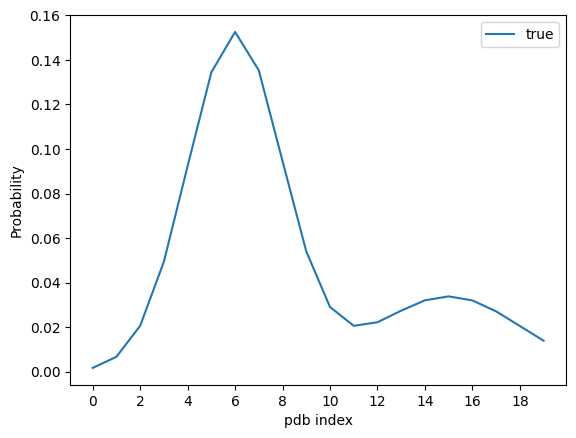

In [3]:
def GaussianMixture1D(weights, means, std_devs):
    weights = jnp.array(weights)
    means = jnp.array(means)
    std_devs = jnp.array(std_devs)
    mixing_dist = numpyro_dist.Categorical(probs=weights/jnp.sum(weights))
    component_dist = numpyro_dist.Normal(loc=means, scale=std_devs) 
    return numpyro_dist.MixtureSameFamily(mixing_dist, component_dist) 

weights = [1., 1./3.]
means = [6., 15.]
std_devs = [2.0, 3.0]
mixture = GaussianMixture1D(weights, means, std_devs)
samples = mixture.sample(jax.random.PRNGKey(0), (10000,))
 
# compute pdf output on a 1d grid
x = jnp.linspace(0, 19, 20)
dx = x[1] - x[0]
    
# normalize output to integrate to 1 on the grid 
true_weights = jnp.exp(mixture.log_prob(x))
true_weights /= dx*true_weights.sum() 
plt.plot(x, true_weights, label='true', color="C0")
plt.xticks(jnp.arange(0, 20, 2))
plt.xlabel('pdb index')
plt.ylabel('Probability')  
plt.legend()
plt.show()

#jnp.save("true_weights.npy", true_weights)

# Define a config file for image simulation
### NOTE: for illustrative purposes, the SNR below is set VERY low

In [4]:
# REPLACE with your own favorite directory that can have big files dropped in it
base_directory = "/mnt/home/levans/ceph/cryojax_particles/"
#base_directory = "My favorite directory"

# Adjust names as needed, for saving configs and big image files
path_to_starfile = base_directory + "my_starfile.star"
path_to_images = base_directory

#### Bare bones config for this notebook
## Things that may need to be adjusted:
##   number of images, noise_snr
## Everything else, unlikely
config = {
"number_of_images": 1000,
"snr": 0.001,
"weights_models": true_weights,
"models_fnames": model_fnames, 
"path_to_models": path_to_models, 
"path_to_starfile": path_to_starfile,
"path_to_images": path_to_images,
"box_size": 128,
"rng_seed": 0,
"pixel_size": 1.6,
}

# Make the parameter file for the dataset and prep the simulator

In [5]:
# Generate RNG keys
number_of_images = config["number_of_images"]
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# make instrument confg
instrument_config = utils.instrument_config_from_params(config)

# make parameters
particle_parameters = sim.make_particle_parameters(keys, instrument_config)

# generate the a "starfile", I/O paradigm for software Relion
new_parameters_file = RelionParticleParameterFile(
    path_to_starfile=config["path_to_starfile"],
    mode="w",
    exists_ok=True,
)
new_parameters_file.append(particle_parameters)
new_parameters_file.save(overwrite=True)

particle_dataset = RelionParticleStackDataset(
    parameter_file=new_parameters_file,
    path_to_relion_project=config["path_to_images"],
    mode="w",
    mrcfile_settings={"overwrite": True}
)

# Create static image formation stuff: potentials, potential integrator
imaging_args = utils.build_image_formation_stuff(config)



# Simulate a dataset!

In [6]:
snr = config["snr"]
mask = op.CircularCosineMask(
    coordinate_grid=instrument_config.coordinate_grid_in_pixels,
    radius=instrument_config.shape[0] //2,
    rolloff_width=0.0
)

constant_args = (imaging_args["potentials"], imaging_args["potential_integrator"], mask, snr)
#print(imaging_args["potentials"])
# Generate RNG keys for per-image noise, and per-image conformations
keys_noise = jax.random.split(jax.random.key(0), number_of_images)
#keys_structure = jax.random.split(jax.random.key(0), number_of_images)
key_structure = jax.random.key(1)

# Generate the per-image conformation assignments: ensemble_weights determines proportion of images simulated at each pdb
ensemble_weights = imaging_args["weights"]
potential_ids = jax.random.choice(
        key_structure, ensemble_weights.shape[0], shape=(number_of_images,), p=ensemble_weights
)

per_particle_args = (keys_noise, potential_ids)

simulate_particle_stack(
    particle_dataset,
    compute_image_fn=sim.compute_image,
    constant_args=constant_args,
    per_particle_args=per_particle_args,
    batch_size=10,
    images_per_file=50,
    overwrite=True
)

### Load Images from Disk, and plot some of them

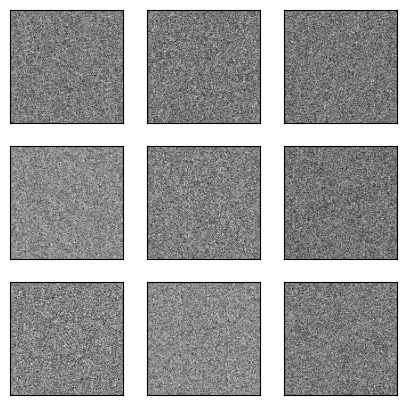

In [8]:
# check first 9 images
image_batch = particle_dataset[0:9]["images"]
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(image_batch[idx, :], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)

# Save a numpy file to disk if needed

In [ ]:
#jnp.save(base_directory + "hsp90_low_snr_images.npz", particle_reader[:].images)


: 

# Put everything in a dataloader that can be batched up for likelihoods
Below i've set the batch size to the size of the dataset, may need to adjust!

In [9]:
# Now, put it in a dataloader
dataloader = jdl.DataLoader(
    utils.CustomJaxDataset(
        particle_dataset
    ),  # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
    backend="jax",  # Use 'jax' backend for loading data
    batch_size=config["number_of_images"],  # Batch size
    shuffle=False,  # Shuffle the dataloader every iteration or not
    drop_last=False,  # Drop the last batch or not
)

# Compute Image-structure likelihoods
This returns a matrix where the entires are $log p(y_i | x_m)$ for image $y_i$ and stucture $x_m$

NOTE: these likelihoods have ground truth knowledge of pose, params, variance, noise, etc, its using the same imaging args and params as the generated images!


In [10]:
log_likelihood = ll.compute_likelihood_matrix_with_lax_map(
    dataloader,
    args = (imaging_args["potentials"], 
        imaging_args["potential_integrator"]),
    batch_size_potentials=1,
    batch_size_images=100,
)
jnp.save("log_likelihood.npy", log_likelihood)

# Estimate the populations of each image class
### NOTE: the example here is known to be an example where the structures are close enough that the ensemble reweighting optimization will "overfit" with too many iterations, if snr is set low enough above. this is a big TBD as far as cases to handle with these sorts of approaches

The "ensemble reweighting" here is from the "multiplicative gradient" function implemented [here](https://github.com/Quantitative-Heterogeneity/cryo_reweighting/blob/main/src/cryo_reweighting/optimization.py)

Below is every function used in the file, its not that much code and can be easily adjusted

*For Example*: One could output the value of the loss over the course of optimization. 
The loss decreases at every iteration, as this is an "expectation maximization" approach and has that same property, but clearly the minimum loss (maximum log marginal likelihood), is not always desirable...see example below. Some sort of early stopping is needed, which for now can be enforced by the `tol` parameter, larger values will stop it earlier.



In [11]:

def multiplicative_gradient(
    log_likelihood,
    tol: Optional[float] = 1e-8,
    max_iterations: Optional[float] = 100000,
    verbose: Optional[bool]=False
):
    num_images, num_structures = log_likelihood.shape

    # Initialize Weights
    weights = (1/num_structures)*jnp.ones(num_structures)

    
    # Subtracting the largest entry from each row of likelihood
    # The gradient is invariant to row scaling of likelihood, so this is valid
    # With this, we avoid working in log space for the grad and loss
    log_likelihood = log_likelihood - jnp.max(log_likelihood, 1)[:, jnp.newaxis]
    
    # NOTE: we cannot exponentiate this if previous step hasn't happened 
    likelihood = jnp.exp(log_likelihood)
    
    for k in range(max_iterations):

        # Update weights
        grad = grad_log_prob(weights, likelihood)   
        weights = update_weights(weights, grad)

        # Check stopping criterion: this `gap` is an upper bound on our loss compared to optimal weights
        gap = jnp.max(grad) - 1
        if verbose:
            if k % 100 == 0: 
                print(f"Number of iterations:{k}")
                print(f"Gap: {gap}") 
        if gap < tol:
            print(f"Number of iterations: {k}")
            print("exiting!")
            break

    return weights

@jax.jit
def grad_log_prob(weights, likelihood):
    model = jnp.sum(likelihood*weights, axis=1)
    grad = jnp.mean(likelihood/model[:, jnp.newaxis], axis=0) 
    return grad

@jax.jit
def update_weights(weights, grad):
    weights = weights*grad
    return weights


@jax.jit
def update_stats(likelihood, weights):
    #TODO: other stats will go in here
    loss = -jnp.mean(jnp.log(likelihood*weights), axis=1) 
    return loss

Number of iterations: 12517
exiting!


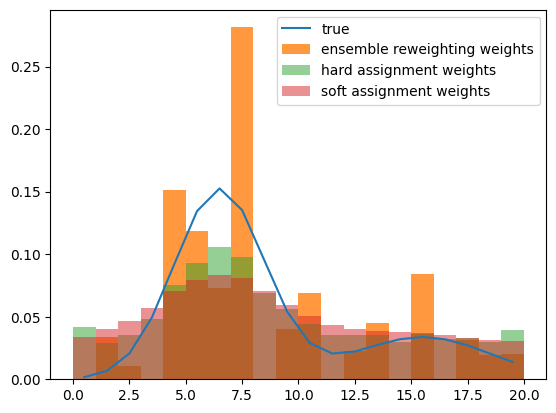

In [12]:
nodes = jnp.arange(0, 20, 1) + 0.5

# get hard classification stuff, and its estimated populations
x = jnp.argmax(log_likelihood, axis = 1)
hard_weights, _ = jnp.histogram(x, bins =jnp.arange(0, 21, 1))
hard_weights /= jnp.sum(hard_weights)

# get soft classification stuff, and its estimated populations
soft_weights = multiplicative_gradient(log_likelihood, max_iterations=1)

# get ensemble reweighting stuff (here is where some messing with hyperparams like tol and max_iterations may be useful)
ensemble_weights = multiplicative_gradient(log_likelihood, tol=1e-8)

plt.plot(nodes, true_weights, label='true', color="C0")
plt.bar(nodes, ensemble_weights, 
        width=1, label='ensemble reweighting weights', color="C1", alpha=0.8)
plt.bar(nodes, hard_weights, 
        width=1, label='hard assignment weights', color="C2", alpha=0.5)
plt.bar(nodes, soft_weights, 
        width=1, label='soft assignment weights', color="C3", alpha=0.5)
plt.legend()

### To investigate, setting "stopping tolerance" to -1, meaning it won't stop until it hits prescribed number of maximum iterations

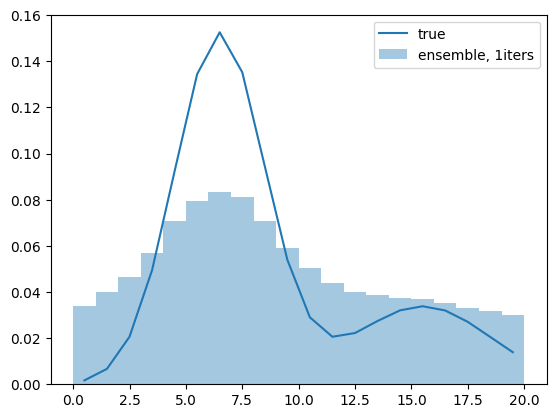

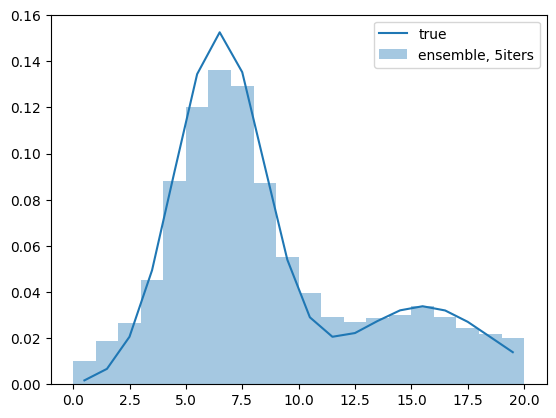

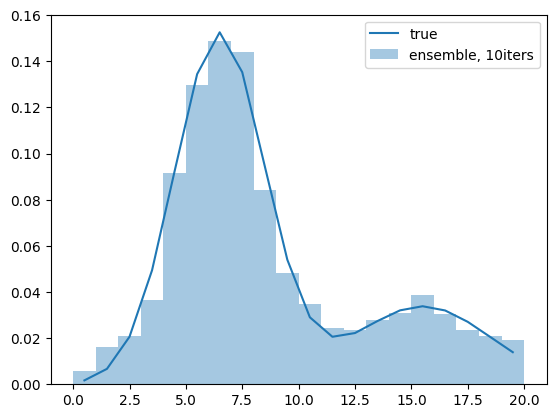

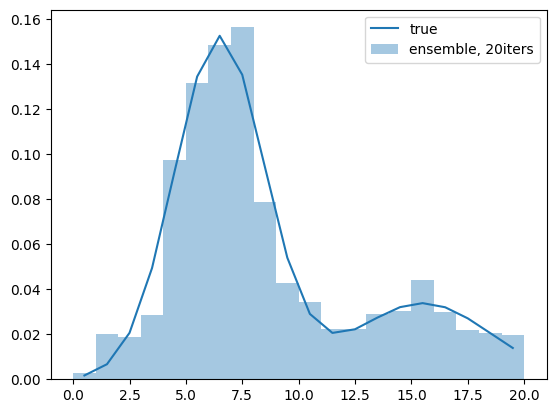

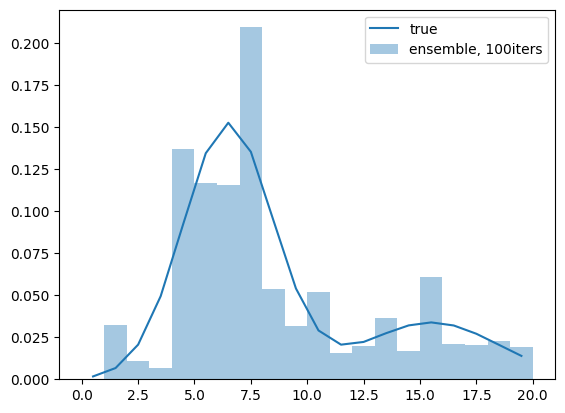

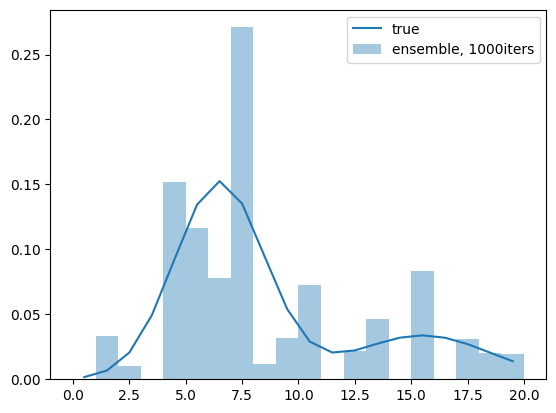

In [13]:
num_iterations = [1, 5, 10, 20, 100, 1000] 
for iters in num_iterations:
    plt.figure()
    plt.plot(nodes, true_weights, label='true', color="C0")
    ensemble_weights = multiplicative_gradient(log_likelihood, tol=-1, max_iterations=iters)
    plt.bar(nodes, ensemble_weights, 
            width=1, alpha=0.4, label=f"ensemble, {iters}iters")
    plt.legend()


## Exercise for the reader: output the loss at various iterations above